# Frac Production Modeling
This is a continuation of Frac Produciton Data Cleaning and Frac Production Analysis notebooks.

Here I will model with the data and optimize the models and features.

In [1]:
# Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model Imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

Great, now I will write two functions to streamline training and testing the models.  The training function will fit the model and then cross validate the scores and return the scores.  The test function will cross validate and return the scores.

In [2]:
def train_model(model, X, Y, cv):
    model.fit(X, Y)
    scores = cross_val_score(model, X, Y, cv=cv)
    return 'Training Scores: {:0.4f} (+/- {:0.4f})'.format(scores.mean(), scores.std()*2)

def test_model(model, X, Y, cv):
    scores = cross_val_score(model, X, Y, cv=cv)
    return 'Test Scores: {:0.4f} (+/- {:0.4f})'.format(scores.mean(), scores.std()*2)


In [3]:
# Reading in ALL Colorado Features (pre-feature selection)
co_all = pd.read_csv('fracwells_co.csv', index_col=0)
co_all.head()

,WellName,WellNumber,OperatorAlias,Field,TargetFormation,TotalDepth,VerticalDepth,DrillType,UpperPerforation,LowerPerforation,...,CumOil,First6BOE,FirstProdDate,Township,Range,slick,gel,xlinkgel,hybrid,sandmass
APINumber,,,,,,,,,,,,,,,,,,,,,
5001097530000,WEP,4-28-11-3-64,AXIS ENERGY,DJ HORIZONTAL NIOBRARA,NIOBRARA,11431.00,7551.00,H,7519.0,11431.0,...,21072.0,10662.0,2017-04-01,03S,64W,0,0,0,0.0,0.000000e+00
5001097540000,WEP,1-28-11-3-64,AXIS ENERGY,DJ HORIZONTAL NIOBRARA,NIOBRARA,11715.00,7594.00,H,8151.0,11715.0,...,23517.0,13185.0,2013-02-01,03S,64W,0,0,0,0.0,0.000000e+00
5001098010000,SHARP,24-3-11HC,WARD PETR,WATTENBERG,CODELL,10161.00,7774.00,H,NaN,NaN,...,142659.0,46241.0,2015-01-01,01S,67W,1,0,1,1.0,2.533881e+06
5001097850000,STATE OF CO,1S-66-36-1609CH,EXTRACTION O&G,THIRD CREEK,NIOBRARA,12177.31,7576.73,H,NaN,NaN,...,16285.0,7094.0,2014-06-01,01S,66W,1,0,1,1.0,3.274332e+06
5001097830000,STATE OF CO,1S-66-36-0108BH,EXTRACTION O&G,THIRD CREEK,NIOBRARA,12164.98,7511.68,H,NaN,NaN,...,16458.0,8304.0,2014-06-01,01S,66W,1,0,1,1.0,3.045143e+06


## Modeling with ALL Colorado Features

In [4]:
# Dropping well identifiers
co_all = co_all.drop(['OperatorAlias','WellName','WellNumber','Township','Range','Field',
                      'FirstProdDate','CumBOE','CumGas','CumOil'], axis=1)

co_all = co_all.dropna(axis=0)
co_all_d = pd.get_dummies(co_all)

co_all_features = co_all_d.drop('First6BOE', axis=1)
co_all_target = co_all_d['First6BOE']

Xa_train, Xa_test, ya_train, ya_test = train_test_split(co_all_features, co_all_target, test_size=0.25, random_state=42)

### Random Forest Regression

In [5]:
# Instantiate the model
rfra = RandomForestRegressor()
# Fit the model and generate training scores
rfra_train = train_model(rfra, Xa_train, ya_train, 5)
# Generate test scores
rfra_test = test_model(rfra, Xa_test, ya_test, 5)
print(rfra_train)
print(rfra_test)

Training Scores: 0.5452 (+/- 0.0792)
Test Scores: 0.4898 (+/- 0.1184)


In [6]:
from sklearn.feature_selection import RFE
rfr = RandomForestRegressor()
selector = RFE(rfr)
selector = selector.fit(co_all_features, co_all_target)

sel_features = pd.DataFrame(selector.support_,
                                   index = co_all_features.columns,
                                    columns=['Selected']).sort_values('Selected', ascending=False)
sel_features

,Selected
TotalDepth,True
gel,True
TargetFormation_NIOBRARA,True
VerticalDepth,True
sandmass,True
hybrid,True
xlinkgel,True
TargetFormation_CODELL,True
slick,True
HorizontalLength,True


From this recursive feature elimination, I will need to eliminate the Target Formation feature and the Drill Type feature, as they are the least important in this model.

In [7]:
co_all = co_all.drop(['DrillType','TargetFormation'], axis=1)

Now, let's get a final baseline of these features for modeling using the random forest regressor.  I need to drop features and then split again.

In [8]:
co_all = pd.get_dummies(co_all)

co_sel_features = co_all.drop('First6BOE', axis=1)
co_all_target = co_all['First6BOE']

Xs_train, Xs_test, ys_train, ys_test = train_test_split(co_sel_features, co_all_target, test_size=0.25, random_state=42)

Now, let's check how these selected features did with the random forest model.

In [9]:
# Instantiate the model
rfrs = RandomForestRegressor()
# Fit the model and generate training scores
rfrs_train = train_model(rfrs, Xs_train, ys_train, 5)
# Generate test scores
rfrs_test = test_model(rfrs, Xs_test, ys_test, 5)
print(rfrs_train)
print(rfrs_test)

Training Scores: 0.5493 (+/- 0.0507)
Test Scores: 0.4863 (+/- 0.1150)


In [10]:
feature_importances = pd.DataFrame(rfrs.feature_importances_,
                                   index = Xs_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
TotalDepth,0.266095
LowerPerforation,0.182123
GrossPerforatedInterval,0.137618
VerticalDepth,0.105187
sandmass,0.097285
UpperPerforation,0.093268
HorizontalLength,0.090393
TreatmentJobCount,0.009567
hybrid,0.005721
gel,0.005695


Alright, this is our baseline model now.  An R-squared value of 0.49 (+/- 0.11).  Interestingly enough, the four different frac method types are the least important in terms of feature importance.  I will continue with this analysis using the engineered features.

## Modeling with Selected and Engineered Features
Now I will try with the engineered features to see how they performed.

In [11]:
# Reading in Colorado Features
cofeatures = pd.read_csv('cofeatures.csv', index_col=0)
cofeatures.head()

,gel,slick,xlinkgel,hybrid,VerticalDepth,HorizontalLength,GrossPerforatedInterval,nphf_sqrt,sandmass,sqrtsandmass,...,TargetFormation_NIOBRARA,TargetFormation_OTHER,hzlen_bin_<1,hzlen_bin_1-2,hzlen_bin_>2,nphf_bin_vertperf,nphf_bin_parthoriz,County_Adams,County_Larimer,County_Weld
APINumber,,,,,,,,,,,,,,,,,,,,,
5001098010000,0,1,1,1.0,7774.00,2247.84,2901.282977,73.120155,2.533881e+06,1591.816874,...,0,0,1,0,0,1,0,1,0,0
5001097820000,0,1,1,1.0,7574.72,4525.40,5120.217574,73.519946,2.784211e+06,1668.595385,...,1,0,1,0,0,1,0,1,0,0
5001098410000,0,0,0,0.0,8045.00,4463.02,5059.443262,73.509025,3.141628e+06,1772.463745,...,0,0,1,0,0,1,0,1,0,0
5001098450000,0,1,0,0.0,7841.00,4658.59,5249.979204,73.543258,3.998957e+06,1999.739152,...,0,0,1,0,0,1,0,1,0,0
5001098470000,0,1,0,0.0,7707.00,5786.57,6348.924499,73.740393,3.938537e+06,1984.574673,...,0,0,1,0,0,1,0,1,0,0


Knowing that this data is clean, I will first identify my variables, with the first 6 month's production as the target and the remainder as features in the model.  I will then split both variables into training and test sets.

In [12]:
# Identifying all engineered features
cofeats = cofeatures.drop(['First6BOE', 'sandmass', 'HorizontalLength', 
                           'GrossPerforatedInterval'], axis=1)

target = cofeatures.First6BOE

X_train, X_test, y_train, y_test = train_test_split(cofeats, target, test_size=0.25, random_state=42)

### Multivariate Linear Regression
I will start with multivariate linear regression to see how well the model can predict production.

In [13]:
# Instantiate the model
regr = LinearRegression()
# Fit the model and generate training scores
regr_train = train_model(regr, X_train, y_train, 5)
# Generate test scores
regr_test = test_model(regr, X_test, y_test, 5)
print(regr_train)
print(regr_test)

Training Scores: 0.3798 (+/- 0.0500)
Test Scores: 0.3367 (+/- 0.1915)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Well, that's not great.  The multivariate linear regression model only explains 34% of the variance of the model.  

Let's try some other models to see how they do.

### Random Forest Regression
The next model I will use to predict production is random forest regression. 

In [18]:
# Instantiate the model
rfr = RandomForestRegressor(random_state=42)
# Fit the model and generate training scores
rfr_train = train_model(rfr, X_train, y_train, 5)
# Generate test scores
rfr_test = test_model(rfr, X_test, y_test, 5)
print(rfr_train)
print(rfr_test)

Training Scores: 0.5964 (+/- 0.0707)
Test Scores: 0.4964 (+/- 0.2444)


In [15]:
feature_importances2 = pd.DataFrame(rfr.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances2

,importance
hzlen_bin_<1,0.228478
VerticalDepth,0.203352
nphf_sqrt,0.109171
sqrtsandmass,0.098237
sandperft,0.092289
hzlen_bin_>2,0.075661
location,0.059558
hybrid,0.049961
hzlen_bin_1-2,0.025449
xlinkgel,0.025061


That's better, except the variance in the scores increased from the linear regression models and our baseline without engineered features, which is indicative of some overfitting.  

Also based on the feature importances in this model and also from the feature selection on the non-engineered features, I will drop the county and target formation features. Interestingly enough, both square root of sand mass and the sand per foot seem to be of great importance to this model.  Let's see how the models differ with each individually to see which to keep.

In [20]:
# Instantiate the model
print('With Square Root Sand Mass')
rfr = RandomForestRegressor(random_state=42)
# Fit the model and generate training scores
rfr_train = train_model(rfr, X_train.drop('sandperft', axis=1), y_train, 5)
# Generate test scores
rfr_test = test_model(rfr, X_test.drop('sandperft', axis=1), y_test, 5)
print(rfr_train)
print(rfr_test)
print()

# Instantiate the model
print('With Sand Mass per Foot')
rfr = RandomForestRegressor(random_state=42)
# Fit the model and generate training scores
rfr_train = train_model(rfr, X_train.drop('sqrtsandmass', axis=1), y_train, 5)
# Generate test scores
rfr_test = test_model(rfr, X_test.drop('sqrtsandmass', axis=1), y_test, 5)
print(rfr_train)
print(rfr_test)

With Square Root Sand Mass
Training Scores: 0.5968 (+/- 0.0681)
Test Scores: 0.5013 (+/- 0.2827)

With Sand Mass per Foot
Training Scores: 0.5961 (+/- 0.0637)
Test Scores: 0.4949 (+/- 0.2669)


It looks like while the square root of sand mass has a higher R-squared score, it also has a higher variance, and the variance difference is larger than the R-squared difference.  For this reason I will keep the sand mass per foot.  This will also relieve some of the dependence between sand mass and lenght or depth.

In [21]:
# Dropping the least important features, Target Formation, County, 
# binned non-perforated ft, and square root sand mass
cofeats2 = cofeats.drop(['TargetFormation_CODELL', 'TargetFormation_NIOBRARA', 'TargetFormation_OTHER',
                        'County_Weld', 'County_Larimer', 'County_Adams',
                        'nphf_bin_parthoriz', 'nphf_bin_vertperf', 'sqrtsandmass'], axis=1)

# Re-splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(cofeats2, target, test_size=0.25, random_state=42)

Great, now that the features have been pared down, I will use a GridSearchCV to optimize the parameters of the model.  I will optimize the number of estimators, the max features used, the minimum samples split, and the max depth of the tree all for the engineered features.

In [27]:
# Identifying potential parameters
param_grid = { 
            "n_estimators"      : [200, 400, 600],
            "max_features"      : ["sqrt"],
            "min_samples_split" : [2,4,6,8],
            "max_depth": [4,6,8,10]
            }
# Instantiating grid search
grid = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5)
# Fitting model
grid.fit(X_train, y_train)
# Identifying best score and best parameters from the Grid Search
print(grid.best_score_)
best_params = grid.best_params_
print(best_params)

0.6224043221466334
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 600}


Now that GridSearchCV has identified the optimal parameters from the set, I will use those parameters to fit a model and see what the training and test set scores look like.

In [28]:
# Instantiate the model
rfr_grid = RandomForestRegressor(**best_params)
# Fit the model and generate training scores
rfr_grid_train = train_model(rfr_grid, X_train, y_train, 5)
# Generate test scores
rfr_grid_test = test_model(rfr_grid, X_test, y_test, 5)
print(rfr_grid_train)
print(rfr_grid_test)

Training Scores: 0.6219 (+/- 0.0586)
Test Scores: 0.5703 (+/- 0.1404)


Even better! The test score mean increased, but there is still a sizable variance in the scores between the folds. 

Let's check out the different feature importances to see what features are influencing the model most.

In [29]:
feature_importances3 = pd.DataFrame(rfr_grid.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances3

,importance
hzlen_bin_<1,0.198468
VerticalDepth,0.196298
hzlen_bin_>2,0.163456
sandperft,0.162055
nphf_sqrt,0.117981
location,0.067254
hybrid,0.036076
hzlen_bin_1-2,0.029880
xlinkgel,0.020856
gel,0.007160


## Gradient Boosting Regressor

In [31]:
gbr = GradientBoostingRegressor(random_state=42)
# Fit the model and generate training scores
gbr_train = train_model(gbr, X_train, y_train, 5)
# Generate test scores
gbr_test = test_model(gbr, X_test, y_test, 5)
print(gbr_train)
print(gbr_test)

Training Scores: 0.5667 (+/- 0.0680)
Test Scores: 0.5250 (+/- 0.1528)


Well, this is an improvement over the random forest baseline.  Let's optimize the parameters for this model and see if the R-squared score will increase.

In [32]:
param_grid = {
               'learning_rate':[0.1,0.2],
                'n_estimators':[100,200,300],
               'min_samples_split':[12,16,24],
               'min_samples_leaf':[2,5,10],
               'max_depth':[4,6,8],
               'max_features':['sqrt'],
               'subsample':[0.8]
}

# Instantiating and fitting grid search
grid = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

# Identifying best score and best parameters from the Grid Search
print(grid.best_score_)
best_params = grid.best_params_
print(best_params)

0.6389213350110406
{'learning_rate': 0.1, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 100, 'subsample': 0.8}


Now that GridSearchCV has identified the optimal parameters from the set, I will use those parameters to fit a model and see what the training and test set scores look like.

In [35]:
# Instantiate the model
gbr_grid = GradientBoostingRegressor(**best_params, random_state=42)
# Fit the model and generate training scores
gbr_grid_train = train_model(gbr_grid, X_train, y_train, 5)
# Generate test scores
gbr_grid_test = test_model(gbr_grid, X_test, y_test, 5)
print(gbr_grid_train)
print(gbr_grid_test)

Training Scores: 0.6389 (+/- 0.0526)
Test Scores: 0.5588 (+/- 0.1625)


Even better! The test score mean increased, but there is still a sizable variance in the scores between the folds. 

Let's check out the different feature importances to see what features are influencing the model most.

In [38]:
feature_importances4 = pd.DataFrame(gbr_grid.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances4

,importance
VerticalDepth,0.279008
sandperft,0.263926
nphf_sqrt,0.260859
location,0.070717
hzlen_bin_<1,0.041776
hzlen_bin_>2,0.041288
hybrid,0.015821
hzlen_bin_1-2,0.009908
xlinkgel,0.009735
gel,0.006134


## Random Forest Quantile Regressor
Because my features and especially my target are non-normally distributed even after tranformations, I will try a random forest quantile regressor.  In a quantile decision tree, the trees predict the percentile and quantile for the data point.  This means that each sample is searched for a leaf that it falls into and a weight is given to that data point based on the fraction of samples in that same leaf, and the weights are summed and averaged.  The output is then the percentile of the data set.

In [30]:
from skgarden import RandomForestQuantileRegressor
rfqr = RandomForestQuantileRegressor(random_state=42)
rfqr_train = train_model(rfqr, X_train, y_train, 5)
rfqr_test = test_model(rfqr, X_test, y_test, 5)
print(rfqr_train)
print(rfqr_test)

Training Scores: 0.5961 (+/- 0.0637)
Test Scores: 0.4949 (+/- 0.2669)




I will use a GridSearchCV to optimize the parameters of the model.  I will optimize the number of estimators, the max features used, the minimum samples split, and the max depth of the tree all for the engineered features.

In [36]:
# Identifying potential parameters
param_grid = { 
            "n_estimators"      : [10, 100, 400],
            "max_features"      : ["sqrt"],
            "min_samples_split" : [2,4,6,8],
            "max_depth": [4,6,8,10]
            }
# Instantiating grid search
grid = GridSearchCV(estimator=rfqr, param_grid=param_grid, cv=5)
# Fitting model
grid.fit(X_train, y_train)
# Identifying best score and best parameters from the Grid Search
print(grid.best_score_)
best_params = grid.best_params_
print(best_params)

0.6219171790531932
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 400}


Now that GridSearchCV has identified the optimal parameters from the set, I will use those parameters to fit a model and see what the training and test set scores look like.

In [37]:
# Instantiate the model
rfqr_grid = RandomForestRegressor(**best_params)
# Fit the model and generate training scores
rfqr_grid_train = train_model(rfqr_grid, X_train, y_train, 5)
# Generate test scores
rfqr_grid_test = test_model(rfqr_grid, X_test, y_test, 5)
print(rfqr_grid_train)
print(rfqr_grid_test)

Training Scores: 0.6224 (+/- 0.0587)
Test Scores: 0.5722 (+/- 0.1386)


This looks better! I'm still surprised at how low the overall R-squared score is, but there is a large amount of variablility in this data, not only in the production, but also each of the individual well characteristics, including frac method. 

In [42]:
feature_importances5 = pd.DataFrame(rfqr_grid.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances5

,importance
hzlen_bin_<1,0.200519
VerticalDepth,0.198987
sandperft,0.162514
hzlen_bin_>2,0.155186
nphf_sqrt,0.118537
location,0.068071
hybrid,0.036915
hzlen_bin_1-2,0.030696
xlinkgel,0.021024
gel,0.007035



For now, I will finish analyzing the Colorado data by inspecting the partial dependency plots because the overall goal is to better understand how each feature contributes to the production of the well.  

## Partial Dependency Plots
Partial dependency plots enable a view inside of the black boxes that are random forests.  They show how the outcome depends on each individual feature in the model.  This way we can get "coefficients" for each feature and see anomalies in the patterns.

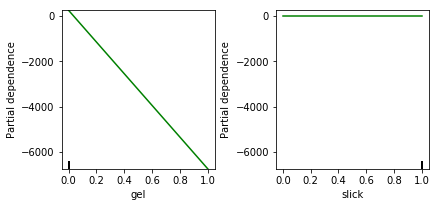

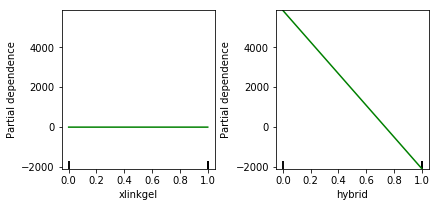

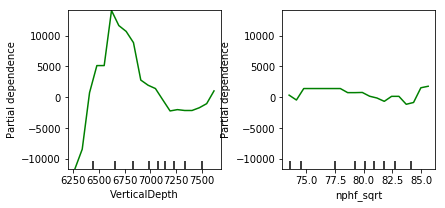

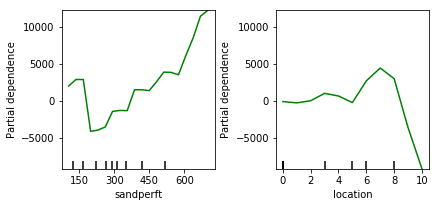

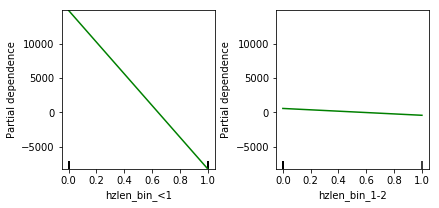

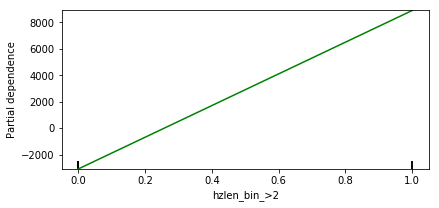

In [43]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

feats = [[0,1],
         [2,3],
        [4,5], 
         [6,7],
        [8,9],
        [10]]

for feat_set in feats:
    gbr_plots = plot_partial_dependence(gbr,
                                features=feat_set, # Column numbers to plot
                                X=X_train, # Raw predictors data
                                n_cols=2,
                                feature_names=X_train.columns, # Labels on graph
                                grid_resolution=20) # Number of values to plot on x-axis

## Frac Well Summary
For this project, I wanted to build models that would help well operators in Colorado both understand the data-based best practices for frac methods, and be able to predict the production of the well within the first six months. The information I used and engineered to perform this analysis were the frac method, namely slickwater, linear gel, crosslinked gel, or a hybrid approach; the drilling conditions, including the horizontal length and the vertical depth of a well; and finally the frac conditions, including the amount of sand used per foot drilled, and the length of un-perforated casing. Through partial dependency plots and feature importances, here are the most important features and how they impact production:
- Horizontal Length
    - Lengths of less than 1 mile had lowest odds of production, between 1 and 2 miles there is very little change in the odds of production, and at greater than two miles of horizontal length there are the greatest odds of higher production levels.
- Vertical Depth
    - The odds of higher production based on vertical depth increases between 6250 ft and peaks at 6600 ft.  After 6600 ft, the odds of higher production decreases.
- Sand per Foot
    - Based on pounds of sand per foot of casing, the odds of higher production are lowest between  0 and 350 pounds of sand per foot, and increase steadily as the amount of sand increases
    
This means that while there is a cost to increasing the each of these attributes of the well, well operators would do well to aim for around 2 miles of horizontal, 6600 ft vertical, and around 600+ pounds of sand per foot of casing.  As for the frac methods, the following are the analysis of their impact on frac production according to the overall model:
- Slickwater
    - Using a slickwater approach had very little impact on the odds of production.  This could be because it is nearly always used, or has very little impact on the production of the well.
- Linear Gel
    - The odds of higher production are higher if a well operator does not use linear gel.
- Cross-linked Gel
    - As with the slickwater approach, using cross-linked gel has very little impact on the odds of production.
- Hybrid Approach
    - The odds of production are higher if a hybrid approach is not used.
    
This is not very informative, most likely because the overall model looked at all attributes of the well, not just the frac method approach.  I will now model only the frac methods to interpret the odds of increased production.

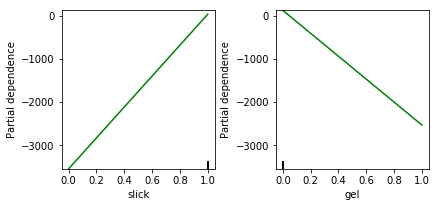

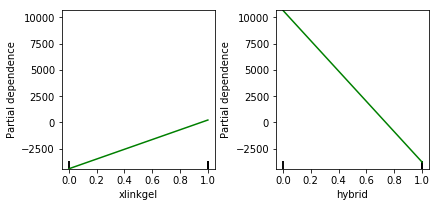

In [45]:
X_method = X_train[['slick', 'gel', 'xlinkgel', 'hybrid']]

gbr_m = GradientBoostingRegressor(random_state=42)
gbr_m.fit(X_method, y_train)

feats = [[0,1],
         [2,3]]

for feat_set in feats:
    gbr_plots = plot_partial_dependence(gbr_m,
                                features=feat_set, # Column numbers to plot
                                X=X_method, # Raw predictors data
                                n_cols=2,
                                feature_names=X_method.columns, # Labels on graph
                                grid_resolution=20) # Number of values to plot on x-axis

According to the model only looking at how frac method affects production, the following are the analysis of their impact on frac production:
- Slickwater
    - Using a slickwater approach increases the odds of higher production.
- Linear Gel
    - The odds of higher production are higher if a well operator does not use linear gel.
- Cross-linked Gel
    - Using a cross-linked gel causes a moderate increase in the odds of higher production.
- Hybrid Approach
    - The odds of production are higher if a hybrid approach is not used.
    
__Overall, a well operator would be best off if they used a slickwater approach or a cross-linked gel approach to fracing, but linear gels and hybrid approaches are not recommended.__  

In [70]:
# Printing models all together
print('Random Forest Regression {}'.format(rfr_grid_test))
print('\nRandom Forest Quantile Regression {}'.format(rfqr_grid_test))
print('\nGradient Boosting Regression {}'.format(gbr_grid_test))

Random Forest Regression Test Scores: 0.5703 (+/- 0.1404)

Random Forest Quantile Regression Test Scores: 0.5722 (+/- 0.1386)

Gradient Boosting Regression Test Scores: 0.5588 (+/- 0.1625)


Overall, all three models were fairly close in their ability to predicte the first 6 months of production, however the best model was the Random Forest Quantile Regression model, with an R-squared value of 0.5722 +/- 0.13. The Random forest regression had an R-squared value of 0.5703 +/- 0.1404, and the gradient boosting regression had the lowest R-squared value of 0.5588 +/- 0.1625. The Gradient boosting regression, along with partial dependency plots, were able to  paint a picture of the importances of the different well and frac characteristics to determine what contributes to higher oil and gas production.